In [1]:
import sys
sys.path.append('..')
sys.path.append('../src')
sys.path.append('../data')

import torch
import plotly.express as px
import src.nanda_plot
from src.model import WrapHookedTransformer
from src.nanda_plot import imshow_reversed, imshow
import pandas as pd
from tqdm import tqdm
import numpy as np

from src.result_analyzer import ResultAnalyzer

%load_ext autoreload
%autoreload 2

In [2]:
model = WrapHookedTransformer.from_pretrained("gpt2")
pad_token = model.tokenizer.pad_token

Using pad_token, but it is not set yet.


Loaded pretrained model gpt2 into HookedTransformer


In [3]:
templates = [
    "{subject} is developed by{object}. {subject} is developed by",
    "{subject} is a {object}. {subject} is a",
]
subjects_obejcts = [
    [("iPhone", " Apple"), ("Android", " Google"), ("Windows", " Microsoft"), ("MacOS", " Apple"),  ("Chrome", " Google"),  ("Safari", " Apple"), ("Edge", " Microsoft"), ("Chromecast", " Google")],
    # [("Italy", " country"), ("France", " country"), ("Germany", " country"), ("Spain", " country"), ("Japan", " country"), ("China", " country"), ("Russia", " country"), ("India", " country"), ("Brazil", " country")],
]
other_objects = [
    [" Apple", " Google", " Microsoft", " Netflix", "Facebook", "Oracle" ],
    # [" nation", " river", " mountain", " planet"]
]

# Generate data
data = []
for template, subjects_object, other_object in tqdm(zip(templates, subjects_obejcts, other_objects), total=len(templates)):
    for subject, object in subjects_object:
        for other in other_object:
            if other == object:
                continue
            data.append(
                {
                    "prompt1": template.format(subject=subject, object=pad_token),
                    "prompt2": template.format(subject=subject, object=other),
                    "true": object,
                    "copy": other,
                    "prediction_1": model.predict(template.format(subject=subject, object=pad_token))[1][0],
                    "prediction_2": model.predict(template.format(subject=subject, object=other))[1][0],
                }
            )
            if data[-1]["prediction_2"] == data[-1]["true"]:
                data[-1]["mem_win"] = True
            else:
                data[-1]["mem_win"] = False
    
    
mem_win = [d for d in data if d["mem_win"]]
mem_lose = [d for d in data if not d["mem_win"]]

print("Memory win:", len(mem_win))
print("Memory lose:", len(mem_lose))

 50%|█████     | 1/2 [00:01<00:01,  1.52s/it]

Memory win: 15
Memory lose: 25


In [4]:
corrected_data = mem_lose

## Patch

In [5]:
pad_token = model.tokenizer.pad_token

In [6]:
clean_prompts = [d["prompt1"] for d in corrected_data]
corrupted_prompts = [d["prompt2"] for d in corrected_data]

In [7]:
def run(model, input):
    logit = torch.zeros(len(input), 50257)
    cache = []
    for i in tqdm(range(len(input))):
        logit[i] = model(input[i])[0,-1,:]
        cache.append(model.run_with_cache(input[i])[1])
    
    return logit, cache

In [8]:
# clean_prompts = [p[0] for p in prompts]
# corrupted_prompts = [p[2] for p in prompts]

corrupted_logit, corrupted_cache = run(model, corrupted_prompts)
clean_logit, clean_cache = run(model, clean_prompts)

  0%|          | 0/25 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:01<00:00, 22.24it/s]


In [9]:
# target_1 = [p[0] for p in target_pair]
# target_2 = [p[1] for p in target_pair]
# tensor_1 = model.to_tokens(target_1, prepend_bos=False)
# tensor_2 = model.to_tokens(target_2, prepend_bos=False)
# # stack the tensors
# target = torch.stack([tensor_1, tensor_2], dim=1).squeeze()
target1 = [d["true"] for d in corrected_data]
target2 = [d["copy"] for d in corrected_data]
tensor_1 = model.to_tokens(target1, prepend_bos=False)
tensor_2 = model.to_tokens(target2, prepend_bos=False)
# stack the tensors
target = torch.stack([tensor_1, tensor_2], dim=1).squeeze()

In [10]:
def to_logit_dif(logit, target):
    logit = torch.log_softmax(logit, dim=1)
    # logit has shape (batch_size, vocab_size), target has shape (batch_size, 2)
    # we want to compute the difference between the two tokens in target for each batch
    # so we need to index logit with target
    logit_diff = torch.zeros(target.shape[0])
    for i in range(target.shape[0]):
        logit_diff[i] = logit[i, target[i,0]] - logit[i, target[i,1]]
    
    # for each batch, we want to compute the difference between the two tokens in target
    # logit_diff = logit_of_target[:, 0] - logit_of_target[:, 1]
    return logit_diff

CLEAN_LOGIT_DIFF = to_logit_dif(clean_logit, target)
CORRUPTED_LOGIT_DIFF = to_logit_dif(corrupted_logit, target)

def normalize_logit_diff(logit_diff):
    return (logit_diff - CLEAN_LOGIT_DIFF) / (CORRUPTED_LOGIT_DIFF - CLEAN_LOGIT_DIFF)

In [11]:
CLEAN_LOGIT_DIFF.mean(), CLEAN_LOGIT_DIFF.std()

(tensor(6.7006), tensor(4.3573))

In [12]:
CLEAN_LOGIT_DIFF

tensor([ 6.4630, 10.3656,  8.6221, 12.3565, 12.6327,  5.9017, 10.8110,  8.2241,
        12.2219,  9.2187, -0.5143,  0.0389,  4.2740, 10.2905,  7.5118,  1.4083,
         0.4488,  4.0229,  9.5335,  7.6828,  1.1999,  0.7163,  2.7712, 11.8172,
         9.4959])

In [13]:
CORRUPTED_LOGIT_DIFF

tensor([-0.5970, -0.4997, -0.5633,  0.6665,  0.9140, -1.0674, -0.1197, -1.9637,
         0.0197, -0.6039, -1.1924, -0.6630, -1.5810, -2.5181, -1.8620, -1.9816,
        -2.6515, -2.8062, -2.5926, -1.6372, -0.3039, -0.2181, -1.3406, -1.4742,
        -2.1520])

## Patch head

In [14]:
#patch attention head
from functools import partial
def run_with_hooks(model, input, hooks, activations):
    max_len = model.to_tokens(input[0]).shape[1]
    logit = torch.zeros(len(input), 50257)
    cache = []
    for i in range(len(input)):
        hook = [(hooks[0],partial(hooks[1], clean_activation=activations[i]))]
        logit[i] = model.run_with_hooks(input[i],
                                        fwd_hooks=hook)[0,-1,:]
        # cache.append(model.run_with_cache(input[i])[1])
    
    return logit

100%|██████████| 12/12 [01:34<00:00,  7.85s/it]


<Axes: title={'center': 'Std logit difference'}>

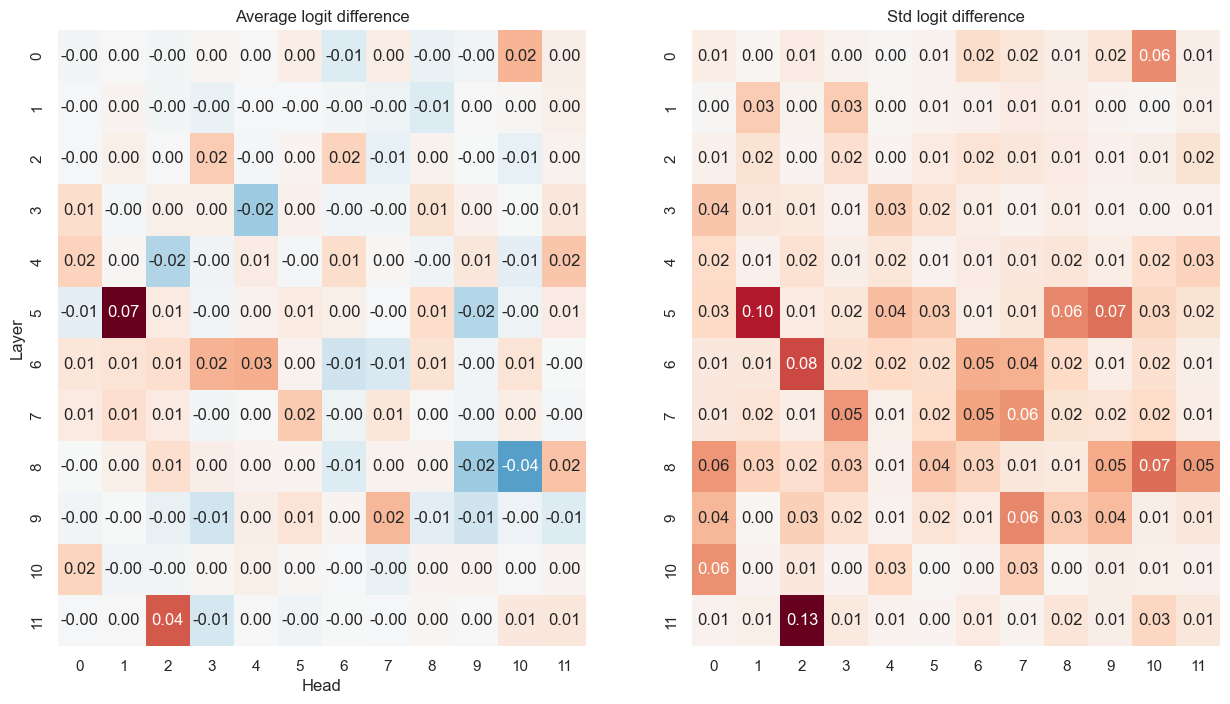

In [15]:
#patch attention head
from functools import partial
from tqdm import tqdm

def heads_hook(activation,hook, head, clean_activation, pos1 = None, pos2=None):
    activation[:, head, :, :] = clean_activation[:, head, :, :]
    return activation

result = torch.zeros((model.cfg.n_layers, model.cfg.n_heads))
result_std = torch.zeros((model.cfg.n_layers, model.cfg.n_heads))
for layer in tqdm(range(model.cfg.n_layers)):
    for head in range(model.cfg.n_heads):
        
        hook = partial(heads_hook, head=head)
        logit = run_with_hooks(model, clean_prompts, hooks=[f"blocks.{layer}.attn.hook_pattern", hook], activations=[cache[f"blocks.{layer}.attn.hook_pattern"] for cache in corrupted_cache])
        
        logit_diff = to_logit_dif(logit, target)
        avg_logit_diff = normalize_logit_diff(logit_diff).mean(dim=0)
        result[layer, head] = avg_logit_diff
        result_std[layer, head] = normalize_logit_diff(logit_diff).std(dim=0)
    
# plot the result as a heatmap
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
sns.set_style("whitegrid", {'axes.grid' : False})
# add also the std heatmap
fig, ax = plt.subplots(1, 2, figsize=(15, 8))
ax[0].set_title("Average logit difference")
ax[1].set_title("Std logit difference")
#make the center of the heatmap 0 and white color
sns.heatmap(result.detach().cpu().numpy(),  annot=True, fmt=".2f", cbar=False, ax=ax[0], center=0.0, cmap="RdBu_r")
#label the axes
ax[0].set_xlabel("Head")
ax[0].set_ylabel("Layer")
sns.heatmap(result_std.detach().cpu().numpy(),  annot=True, fmt=".2f", cbar=False, ax=ax[1],center=0.0, cmap="RdBu_r")



100%|██████████| 12/12 [00:06<00:00,  1.82it/s]


<Axes: title={'center': 'Std logit difference'}>

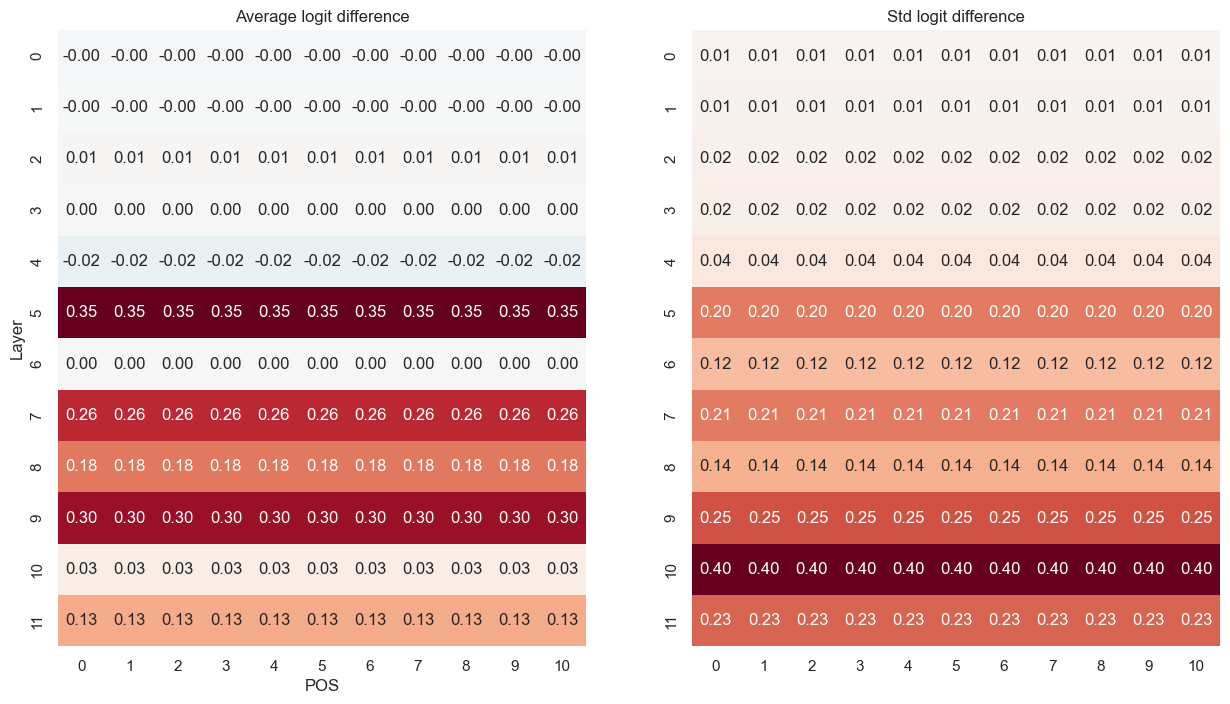

In [16]:
#patch attention head
from functools import partial
from tqdm import tqdm

def out_hook(activation,hook, pos, clean_activation):
    activation[:, pos, :] = clean_activation[:, pos, :]
    return activation

result = torch.zeros((model.cfg.n_layers, 11))
result_std = torch.zeros((model.cfg.n_layers, 11))


for layer in tqdm(range(model.cfg.n_layers)):
        hook = partial(out_hook, pos=-1)
        logit = run_with_hooks(model, clean_prompts, hooks=[f"blocks.{layer}.hook_attn_out", hook], activations=[cache[f"blocks.{layer}.hook_attn_out"] for cache in corrupted_cache])
        
        
        logit_diff = to_logit_dif(logit, target)
        avg_logit_diff = normalize_logit_diff(logit_diff).mean(dim=0)
        result[layer] = avg_logit_diff
        result_std[layer] = normalize_logit_diff(logit_diff).std(dim=0)
        
# plot the result as a heatmap
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
sns.set_style("whitegrid", {'axes.grid' : False})
# add also the std heatmap
fig, ax = plt.subplots(1, 2, figsize=(15, 8))
ax[0].set_title("Average logit difference")
ax[1].set_title("Std logit difference")
sns.heatmap(result.detach().cpu().numpy(),  annot=True, fmt=".2f", cbar=False, ax=ax[0],center=0.0, cmap="RdBu_r")
#label the axes
ax[0].set_xlabel("POS")
ax[0].set_ylabel("Layer")
sns.heatmap(result_std.detach().cpu().numpy(),  annot=True, fmt=".2f", cbar=False, ax=ax[1],center=0.0, cmap="RdBu_r")



  0%|          | 0/12 [00:00<?, ?it/s]

100%|██████████| 12/12 [00:12<00:00,  1.02s/it]


<Axes: title={'center': 'Std logit difference'}>

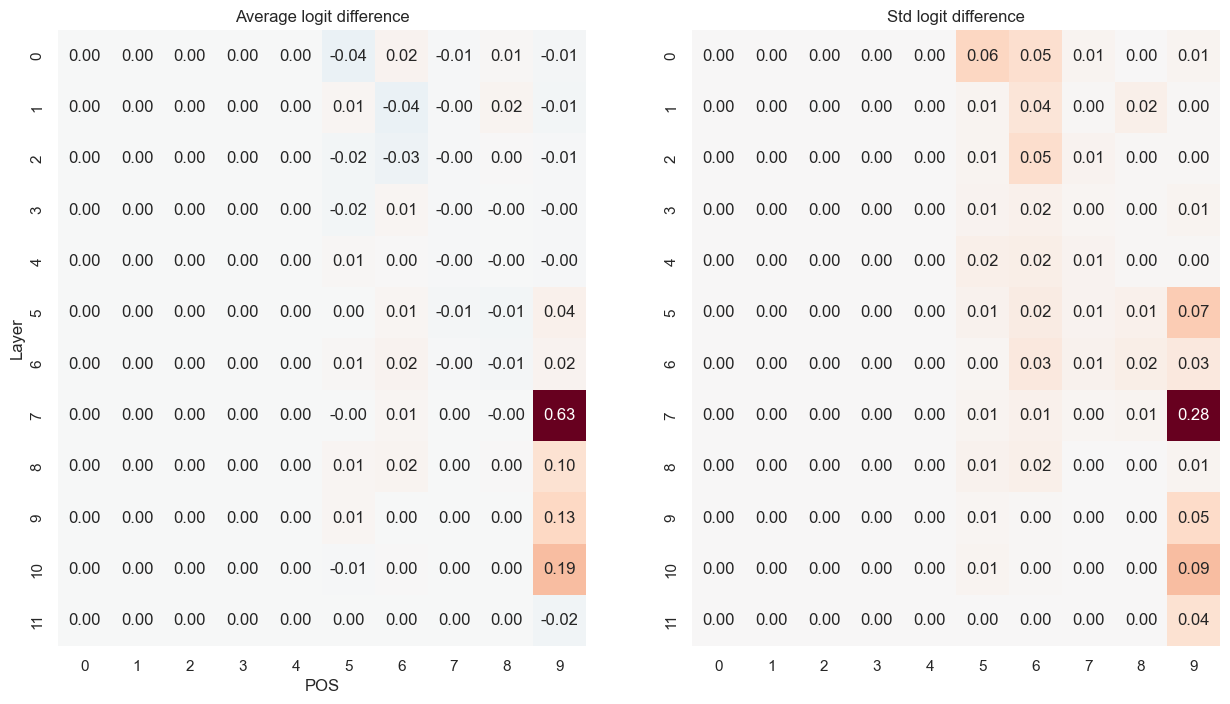

In [27]:
#patch attention head
from functools import partial
from tqdm import tqdm

def out_hook(activation,hook, pos, clean_activation):
    activation[:, pos, :] = clean_activation[:, pos, :]
    return activation

result = torch.zeros((model.cfg.n_layers, 10))
result_std = torch.zeros((model.cfg.n_layers, 10))
for layer in tqdm(range(model.cfg.n_layers)):
    for pos in range(10):
        hook = partial(out_hook, pos=pos)
        logit = run_with_hooks(model, clean_prompts, hooks=[f"blocks.{layer}.hook_attn_out", hook], activations=[cache[f"blocks.{layer}.hook_attn_out"] for cache in corrupted_cache])
        
        logit_diff = to_logit_dif(logit, target)
        avg_logit_diff = normalize_logit_diff(logit_diff).mean(dim=0)
        result[layer, pos] = avg_logit_diff
        result_std[layer, pos] = normalize_logit_diff(logit_diff).std(dim=0)
        
# plot the result as a heatmap
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
sns.set_style("whitegrid", {'axes.grid' : False})
# add also the std heatmap
fig, ax = plt.subplots(1, 2, figsize=(15, 8))
ax[0].set_title("Average logit difference")
ax[1].set_title("Std logit difference")
sns.heatmap(result.detach().cpu().numpy(),  annot=True, fmt=".2f", cbar=False, ax=ax[0],center=0.0, cmap="RdBu_r")
#label the axes
ax[0].set_xlabel("POS")
ax[0].set_ylabel("Layer")
sns.heatmap(result_std.detach().cpu().numpy(),  annot=True, fmt=".2f", cbar=False, ax=ax[1],center=0.0, cmap="RdBu_r")



100%|██████████| 12/12 [00:11<00:00,  1.03it/s]


<Axes: title={'center': 'Std logit difference'}>

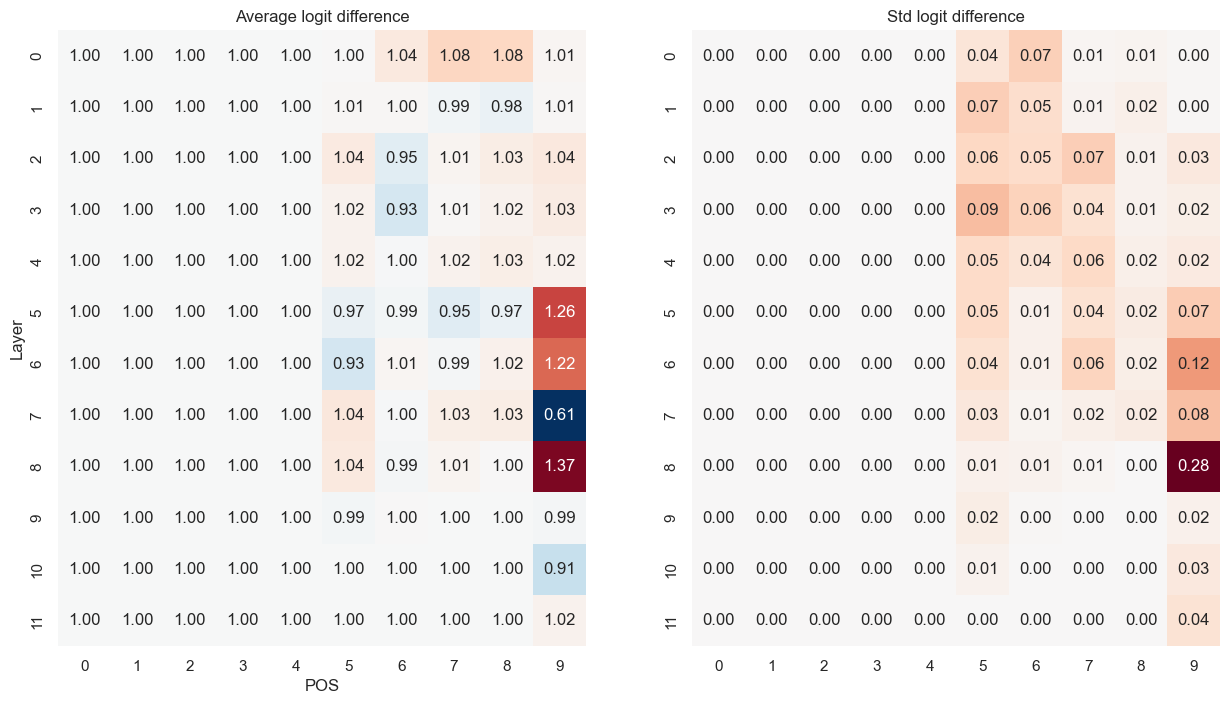

In [106]:
#patch attention head
from functools import partial
from tqdm import tqdm

def out_hook(activation,hook, pos, clean_activation):
    activation[:, pos, :] = clean_activation[:, pos, :]
    return activation

result = torch.zeros((model.cfg.n_layers, 10))
result_std = torch.zeros((model.cfg.n_layers, 10))
for layer in tqdm(range(model.cfg.n_layers)):
    for pos in range(10):
        hook = partial(out_hook, pos=pos)
        logit = run_with_hooks(model, corrupted_prompts, hooks=[f"blocks.{layer}.hook_attn_out", hook], activations=[cache[f"blocks.{layer}.hook_attn_out"] for cache in clean_cache])
        
        logit_diff = to_logit_dif(logit, target)
        avg_logit_diff = normalize_logit_diff(logit_diff).mean(dim=0)
        result[layer, pos] = avg_logit_diff
        result_std[layer, pos] = normalize_logit_diff(logit_diff).std(dim=0)
        
# plot the result as a heatmap
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
sns.set_style("whitegrid", {'axes.grid' : False})
# add also the std heatmap
fig, ax = plt.subplots(1, 2, figsize=(15, 8))
ax[0].set_title("Average logit difference")
ax[1].set_title("Std logit difference")
sns.heatmap(result.detach().cpu().numpy(),  annot=True, fmt=".2f", cbar=False, ax=ax[0],center=1.0, cmap="RdBu_r")
#label the axes
ax[0].set_xlabel("POS")
ax[0].set_ylabel("Layer")
sns.heatmap(result_std.detach().cpu().numpy(),  annot=True, fmt=".2f", cbar=False, ax=ax[1],center=0.0, cmap="RdBu_r")



In [17]:
import circuitsvis as cv
cv.attention.attention_patterns(model.to_str_tokens(clean_prompts[1]), clean_cache["pattern",7][1], )

In [16]:
import circuitsvis as cv
cv.attention.attention_patterns(model.to_str_tokens(corrupted_prompts[1]), corrupted_cache["pattern",7][1], )

In [42]:
model.blocks[7].attn.W_O.shape

torch.Size([12, 64, 768])

In [43]:
corrupted_cache["pattern",7].shape

torch.Size([3, 12, 10, 10])

In [34]:
import einops
output = einops.einsum(corrupted_cache["pattern",7][:,7], model.blocks[7].attn.W_O[7], "b max_len max_len, h_d d -> b max_len d")

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:2                                                                                    │
│                                                                                                  │
│   1 import einops                                                                                │
│ ❱ 2 output = einops.einsum(corrupted_cache["pattern",7][:,7], model.blocks[7].attn.W_O[7], "     │
│   3                                                                                              │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
TypeError: list indices must be integers or slices, not tuple

In [91]:
def to_logit_target(logit, target):
    logit = logit[:, -1, :]
    logit = torch.log_softmax(logit, dim=-1)
    # logit has shape (batch_size, vocab_size), target has shape (batch_size, 2)
    # we want to compute the difference between the two tokens in target for each batch
    # so we need to index logit with target
    
    logit_of_target = logit.gather(dim=1, index=target)
    
    return logit_of_target

In [95]:
def to_residual_direction(cache):
    logit = torch.zeros(len(cache),10, 50257)
    for idx,c in enumerate(cache):
        logit[idx] = einops.einsum(c,model.W_U, "b pos d, d v -> b pos v")
    return logit

In [100]:
def from_pattern_to_output(cache):
    out_matrix = model.blocks[7].attn.W_O
    resid = torch.zeros(len(cache), 10, 768)
    for idx, c in enumerate(cache):
        resid[idx] = einops.einsum(c[:,6], out_matrix[6], "b max_len max_len, h_d d -> max_len d")
    resid_cache = [resid[i].unsqueeze(0) for i in range(len(cache))]
    logit = to_residual_direction(resid_cache)
    return logit

In [101]:
layer = 7
print(to_logit_target(to_residual_direction([cache["resid_pre",layer] for cache in corrupted_cache]), target))
print(to_logit_target(to_residual_direction([cache["resid_mid",layer] for cache in corrupted_cache]), target))
print(to_logit_target(to_residual_direction([cache["resid_post",layer] for cache in corrupted_cache]), target))

tensor([[-10.0264, -10.7921],
        [ -0.1127,  -6.6651],
        [ -0.0149,  -8.2856]])
tensor([[-2.7290e+01, -1.1921e-06],
        [-1.2695e+01, -3.3379e-06],
        [-1.5891e+01, -5.9605e-07]])
tensor([[-33.1263,   0.0000],
        [-18.8525,   0.0000],
        [-23.6173,   0.0000]])


In [98]:
from_pattern_to_output([cache["blocks.7.attn.hook_pattern"] for cache in corrupted_cache]).shape

torch.Size([3, 10, 50257])

In [105]:
print(to_logit_target(from_pattern_to_output([cache["blocks.7.attn.hook_pattern"] for cache in corrupted_cache]), target))


tensor([[-11.0221, -11.4946],
        [-10.5054, -11.7685],
        [-10.5259, -12.1033]])
